# Practical session 4 - K-nearest neighbours (K-NN) classification with numpy, scikit-learn, cython and numba

Students (pair):
- Matthieu Paolo([link](https://github.com/username1))
- Luc Thiebaud([link](https://github.com/username2))

**Useful references for this lab**:

[1] scikit-learn: [documentation](https://scikit-learn.org/stable/modules/neighbors.html?highlight=knn%20classification)

[2] `numba`: [documentation](http://numba.pydata.org/) 

[3] cython: [a very useful tutorial](https://cython.readthedocs.io/en/latest/src/userguide/numpy_tutorial.html#numpy-tutorial), and [another one](http://docs.cython.org/en/latest/src/tutorial/cython_tutorial.html)



## <a name="content">Contents</a>
- [Exercise 1: KNN classification with numpy and sklearn](#ex1)
- [Exercise 2: Code acceleration with cython](#ex2)
- [Exercise 3: Code acceleration with numba](#ex3)
---

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import sklearn
import pandas as pd # j'importe pandas pour visualiser des données plus facilement quand j'en ai besoin
import matplotlib.pyplot as plt
import bottleneck as bn
from sklearn.neighbors import KNeighborsClassifier
import timeit
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

## <a name="ex1">Exercise 1: K-Nearest Neighbours (K-NN) classification with numpy and scikit-learn</a> [(&#8593;)](#content)

This session is a first introduction to classification using the most intuitive non parametric method: the $K$-nearest neighbours. The principle is [the following](https://scikit-learn.org/stable/modules/neighbors.html?highlight=knn%20classification). A set of labelled observations is given as a learning set. A classification taks then consists in assigning a label to any new observation. In particular, the K-NN approach consists in assigning to the observation the most frequent label among its $K$ nearest neighbours taken in the training set.

### A. Validation on synthetic data

Load the training and test datasets `data/synth_train.txt` and `data/synth_test.txt`. Targets belong to the set $\{1,2\}$ and entries belong to $\mathbb{R}^2$. The file `data/synth_train.txt` contain 100 training data samples, and `data/synth_test.txt` contains 200 test samples, where:

- the 1st column contains the label of the class the sample;
- columns 2 & 3 contain the coordinates of each sample (in $\mathbb{R}^2$).

Useful commands can be found below.

```python
# load the training set
train = np.loadtxt('data/synth_train.txt')  #...,delimiter=',') if there are ',' as delimiters
class_train = train[:,0]
x_train = train[:,1:]
N_train = train.shape[0]
```

```python
# load the test set
test = np.loadtxt('/datasynth_test.txt') 
class_test_1 = test[test[:,0]==1]
class_test_2 = test[test[:,0]==2]
x_test = test[:,1:]
N_test = test.shape[0]
```

1\. Display the training set and distinguish the two classes. 

> Hint: useful functions include `matplotlib.pyplot.scatter` or `matplotlib.pyplot.plot`.

**Answer:**

True

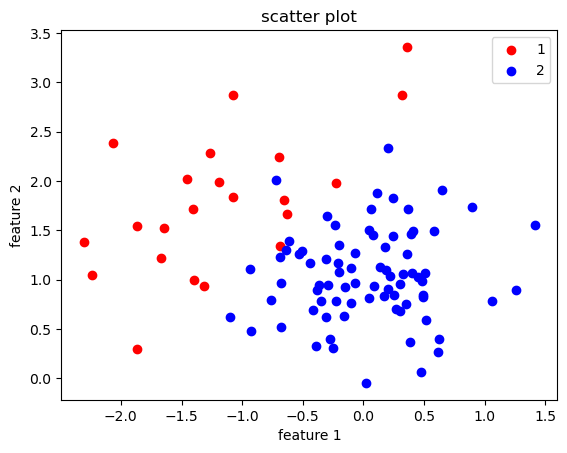

In [3]:
# your code

# load the training set
train = np.loadtxt("C:/Users/lthiebau/Documents/Lab4_Paolo_Thiebaud/data/synth_train.txt")
class_train = train[:,0]
x_train = train[:,1:]
N_train = train.shape[0]

# load the test set
test = np.loadtxt("C:/Users/lthiebau/Documents/Lab4_Paolo_Thiebaud/data/synth_test.txt") 
class_test_1 = test[test[:,0]==1]
class_test_2 = test[test[:,0]==2]
x_test = test[:,1:]
N_test = test.shape[0]

# je crée deux listes vides à laquelle je vais ajouter les vecteurs (colonne) de x_train pour lesquels la clas vaut 1 (resp. 2)
x_train1 = []
x_train2 = []

# je parcours x_train et class_train
for i in range(N_train) :
    if class_train[i] == 1 : # si la target, vaut 1, j'ajoute le tuple à x_train1
        x_train1.append(x_train[i])
    else : # sinon la target vaut 2, j'ajoute le tuple à x_train2
        x_train2.append(x_train[i])
        
# je transforme ces deux "listes de listes" en matrice à 2 colonnes
x_train1 = np.array(x_train1)
x_train2 = np.array(x_train2)

# les éléments du training set dont la target est 1 sont affichés en rouge, ceux dont la target est 2 sont affichés en bleu
plt.scatter(x_train1[:,0], x_train1[:,1], c = 'red', label = '1')
plt.scatter(x_train2[:,0], x_train2[:,1], c = 'blue', label = '2')
plt.title('scatter plot')
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.legend()

# test pour vérifier que l'on a pas oublié d'éléments
x_train.shape[0] == x_train1.shape[0] + x_train2.shape[0]

2\. Implement the K-nearest neighbours algorithm for classification.

> Hint: 
> - useful functions include `numpy.linalg.norm`, `numpy.argsort`, `numpy.bincount`;
> - implement the algorithm as a function rather than an object. This will drastically simplify the acceleration step using Cython.
> - for an optimized partial sorting procedure, you may have a look at the [`bottleneck.argpartition` function](https://bottleneck.readthedocs.io/en/latest/reference.html#bottleneck.argpartition).
> 1. Compute for each row in `x_test` (if necessary use `np.newaxis`) its distance with respect to `x_train`:
>  - Use  `numpy.linalg.norm` (in which dimension this distance is computed ? Consider using `axis` argument)
> 2. Sort the ordered collection of distances (indices from smallest to largest (in ascending order) by the distances):
>   - Use `np.argsort` (at the end replace this procedure by `bottleneck.argpartition`)
>   - Once the sorting is done, we take only the indices of `labels` of the `n_neighbours` nearest neighbours of the `class_train` :
>     - `id = np.argsort(distances)[:n_ neighbours]` and `labels = class_train[id]`
> 3. The K-nearest can be used for **Regression**, in this case it is necessary to return the mean of the K-labels. For **Classification**,  we return the mode of the K-labels :
> - Use `np.bincount` for `labels` to affect the variable `class_pred[q]` (for row `q`). This procedure counts the number of occurrences of each value in array. **Mode** is the value that appears. How can we get this value ?


**Answer:**

In [4]:
# your code

def kNN(x_train, x_test, n_neighbours, class_train) :
    
    r""" 
    Arguments : deux matrices x_train et x_test (à 2 colonnes), n_neighbours le nombre de n plus proches voisins, le vecteur class_train de même taille que le nombre de lignes de x_train
    Return : un vecteur contenant les prédictions des targets pour x_test
    
    """
    # 1. je vais créer une matrice de taille x_test.shape[0], x_train.shape[0] où l'élément d'indice i,j correspond à la distance entre i-ème vecteur (de taille 2) de x_test et le j-ème vecteur de x_train
    mat_distance = np.zeros((x_test.shape[0], x_train.shape[0]))
    
    # boucle for pour parcourir les lignes de x_test
    for i in range(x_test.shape[0]) :
        
        # boucle for pour parcourir les lignes de x_train
        for j in range(x_train.shape[0]) :
            mat_distance[i][j] = np.linalg.norm(x_test[i] - x_train[j], axis = 0) # calcule de la distance en norme 2
            
    # 2. je crée une nouvelle matrice ordered_distance dont la ligne i correspond au classement dans l'ordre croissant des distances entre le i-ème vecteur de x_test et les x_train (NB : on retourne l'indice et non la valeur de la distance quadratique)
    
    ordered_distance = np.argsort(mat_distance, axis = 1)
    
    # NB : si la ligne 0 de ordered_distance est [86 , 20, 47, ...] cela signifie que x_test[0] est le plus proche de x_train[86], puis de x_train[20], etc...
    # je pense que j'utilise une autre méthode que ce qui est demandé dans l'énoncé mais je ne comprend pas bien les indications de l'énoncé
    
    # je crée ensuite une matrice id de taille x_test.shape[0], n_neighbours qui est enfaite une sous-matrice de ordered_distance, où l'on garde seulement les n_neighbours premières lignes
    
    id = ordered_distance[:, :n_neighbours]
    
    # je créer ensuite ma matrice labels qui est une matrice de même taille que id mais je remplace l'indice de x_train (ou class_train) par son label (i.e si x_train[i] est de label 1, je remplace par 1)
    
    labels = np.zeros((id.shape[0], id.shape[1]))
    
    # boucle pour balayer les lignes :
    for i in range(id.shape[0]) :
        # boucle pour balayer les n_neighbours :
        for j in range(id.shape[1]) :
            label_indice = id[i][j]
            labels[i][j] = class_train[label_indice]
    
    # après cette étape on a une matrice de taille nb d'éléments de x_test , n_neighbours, où chaque ligne i correspond au label des n_neighbours les plus proches de l'élément i de x_test
    
    # 3. 
    labels = labels.astype(int) # convertit la matrice de float en int pour utiliser np.bincount
    
    # je crée une boucle for pour balayer chaque ligne de labels et assigner le label le plus fréquent pour chaque ligne i dans une nouvelle matrice class_pred

    class_pred = np.zeros((labels.shape[0]), dtype=int) 
    
    for i in range(labels.shape[0]) :
        
        class_pred[i] = np.bincount(labels[i]).argmax() # sélectionne l'élément le plus fréquent pour chaque ligne
    
    # class_pred est le vecteur des labels des x_test (où le label est celui des n_neighbours plus proches voisins pour chaque élément)
    class_pred = class_pred.astype(float)
    
    return class_pred
    

3\. Compute the error rate on the training set and the test set for $K \in \{1,2, \dotsc, 20\}$. Display the classification result (see 1.) for the configuration with the lowest error rate.

**Answer:**

In [5]:
# your code

# je crée un vecteur erreur de taille 20 dans lequel je vais afficher à la ligne i l'erreur pour n_neighbours = i
error = np.zeros((20))

# boucle for pour parcourir le nombre de n_neighbours (de 1 à 20)
for k in range(1, 21) :
    class_pred = kNN(x_train, x_test, k, class_train) # on entraine x_test avec x_train
    class_test = test[:,0] # contient les labes du test class
    error[k-1] = 1 - np.count_nonzero(class_pred == class_test) / class_pred.shape[0] # par définition erreur = 1 - nb cas correct / nb cas total (ie 1 - accuracy)

print(error)


[0.065 0.06  0.045 0.05  0.06  0.055 0.07  0.07  0.075 0.075 0.09  0.075
 0.08  0.075 0.075 0.075 0.08  0.08  0.08  0.08 ]


4\. Comment on your results. Which value of $K$ seems optimal ?


**Answer:**

In [6]:
# your code

K_optimal = np.argmin(error) + 1
print("K_optimal =", K_optimal, "minimise l'erreur")
print("Pour cette valeur de K, l'erreur est de moins de 5% ce qui est plutôt bon.\nL'erreur demeure en dessous de 10% pour K variant entre 1 et 20")

K_optimal = 3 minimise l'erreur
Pour cette valeur de K, l'erreur est de moins de 5% ce qui est plutôt bon.
L'erreur demeure en dessous de 10% pour K variant entre 1 et 20


5\. Compare the results of you implementation with those of [`sklearn.neighbors.KNeighborsClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html?highlight=kneighborsclassifier#sklearn.neighbors.KNeighborsClassifier). Compare the runtime of these two versions using the [`timeit`](https://docs.python.org/3/library/timeit.html) module (see session 1).

**Answer:**

In [7]:
# your code

# même chose que précédemment,
error_sk = np.zeros((20))
for k in range(1, 21) :
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(x_train, class_train)
    class_pred = neigh.predict(x_test)
    class_test = test[:,0]
    error_sk[k-1] = 1 - np.count_nonzero(class_pred == class_test) / class_pred.shape[0]


print(error_sk.all() == error.all())
print("On obtient les mêmes résultats avec la fonction définie ci-dessus qu'avec sklearn, ce qui est une bonne nouvelle")

True
On obtient les mêmes résultats avec la fonction définie ci-dessus qu'avec sklearn, ce qui est une bonne nouvelle


In [8]:
knn = KNeighborsClassifier(n_neighbors=K_optimal)

def entrainement_sk():
    knn.fit(x_train, class_train)


def entrainement_fonction() :
    kNN(x_train, x_test, K_optimal, class_train)
    
temps_sk = timeit.timeit(entrainement_sk, number=1)
temps_fonction = timeit.timeit(entrainement_fonction, number=1)

print("temps d'éxécution sklearn :", temps_sk,"\ntemps d'éxécution fonction :", temps_fonction)
print("\nutiliser sklearn diminue le temps d'éxécution d'un facteur 100, ce qui est énorme pour la même tâche\nma fonction n'est toutefois pas optimale avec ses nombreuses boucles for")

temps d'éxécution sklearn : 0.000791700000036144 
temps d'éxécution fonction : 0.12005409999994754

utiliser sklearn diminue le temps d'éxécution d'un facteur 100, ce qui est énorme pour la même tâche
ma fonction n'est toutefois pas optimale avec ses nombreuses boucles for


### B. Application to a real dataset (Breast cancer Wisconsin).

6\. Apply the K-NN classifier to the real dataset `data/wdbc12.data.txt.` Further details about the data are provided in `data/wdbc12.names.txt`.

> Hint: you can use the function [`train_test_split` from `sklearn.model_selection`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) to split the dataset into a training and a test set.

**Answer:**

In [10]:
# your code

data = np.loadtxt("C:/Users/lthiebau/Documents/Lab4_Paolo_Thiebaud/data/wdbc12.data.txt", delimiter=',')

# la première colonne contient l'ID du patient, la seconde les targets et les 30 autres les features
X = data[:,2:] # les 30 dernières colonnes
y = data[:,1] # le vecteur target

# on considère 1 quart du datataset dans le test set et 3 quart dans le training set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# création du modèle, je choisis arbitrairement k = 5 après quelques essais, ça donne des bons résultats (on pourrait faire une boucle for pour faire varier k mais ce n'est pas l'objectif de cette partie)
knn = KNeighborsClassifier(n_neighbors=5)

# entrainement 
knn.fit(X_train, y_train) 

# prédiction 
y_pred = knn.predict(X_test)

# évaluation de la précision du modèle
error_score = 1 - accuracy_score(y_test, y_pred) # j'utilise une métrique error_score comme dans la partie précédente

print("error = ", error_score,"\nl'erreur est de moins de 10 %")

error =  0.09790209790209792 
l'erreur est de moins de 10 %


## <a name="ex2">Exercise 2: Code acceleration with cython</a> [(&#8593;)](#content)

Cython allows C code to be easily interfaced with Python. It can be useful to make your code faster for a small coding effort, in particular when using loops. A general approach to optimize your code is outlined in the [Scipy lecture notes, Section 2.4](https://scipy-lectures.org/advanced/optimizing/index.html). Complementary reading about interfacing Python with C can be found in [Section 2.8](https://scipy-lectures.org/advanced/interfacing_with_c/interfacing_with_c.html).

1\. Read carefully the [cython tutorial](http://docs.cython.org/en/latest/src/tutorial/cython_tutorial.html), which describes step by the step how the toy example reported below has been developed.

**Setup**: Compile the toy example provided in `example_cy/` by running, in the command line (anaconda prompt on windows)

```bash
cd example_cy && python setup.py build_ext --inplace
```

Note that the compilation process has been slightly automatised with the instructions reported in `example_cy/setup.py`. To test the module, run

In [10]:
!cd example_cy && python setup.py build_ext --inplace

Compiling helloworld.pyx because it changed.
Compiling primes.pyx because it changed.
[1/2] Cythonizing helloworld.pyx
[2/2] Cythonizing primes.pyx


In [11]:
import example_cy.helloworld as toy

toy.printhello()

Hello World


which should display
```python
Hello World
```

> Warning: 
> - do not forget to include an empty `__init__.py` file in the directory where your source code lives (`import` will fail if this is not the case).
> - in case you have any setup issue, take a look at the `notes.md` file.
> - if the C code and/or the executable do not seem to be regenerated by the build instructions, delete the C code and the executable first, and re-execute the compilation afterwards.
> - do not hesitate to restart the Python kernel if necessary when the Cython executable has been re-generated.

2\. Read the [Numpy/Cython tutorial](https://cython.readthedocs.io/en/latest/src/userguide/numpy_tutorial.html#numpy-tutorial), focussing on the paragraphs **Cython at a glance**, and **Your Cython environment** until **"More generic code"**. An example to compile a `.pyx` file depending on `numpy` is included in `example_np_cy/`.

> Remarks: 
> - the `annotate=True` flag in the `setup.py` allows an additional `.html` document to be generated (`<your_module_name>.html`), showing, for each line of the Cython code, the associated C instructions generated. Highlighted in yellow are the interactions with Python: the darker a region appears, the less efficient the generated C code is for this section. Work in priority on these! 
> - make sure all the previously generated files are deleted to allow the .html report to be generated;
> - if you are working on your own machine and don't have a C/C++ compiler installed, read the notes provided in `notes.md`;
> - use `cdef` for pure C functions (not exported to Python), `cpdef` should be favored for functions containing C instructions and later called from Python.

**Answer:**

In [12]:
# your code
!cd example_np_cy && python setup.py build_ext --inplace

Compiling compute_cy.pyx because it changed.
[1/1] Cythonizing compute_cy.pyx


In [12]:
import example_np_cy.compute_cy as toy
toy.compute(np.array([[2,2]]), np.array([[2,2]]), 8, 6, 3)

array([[31, 31]], dtype=int32)

3\. Use Cython to implement a faster version of the numpy K-NN classifier implemented in [Exercise 1](#ex1). To do so, apply step-by-step the techniques introduced in the [Numpy/Cython tutorial](https://cython.readthedocs.io/en/latest/src/userguide/numpy_tutorial.html#numpy-tutorial) (*i.e.*, compile and time your code after each step to report the evolution, keeping track of the different versions of the cython function).

> Hint: if you keep numpy arrays, make sure you use memory views (see numpy/cython tutorial) to access the elements within it. Be extremely careful with the type of the input arrays (you may need to recast the format of the input elements before entering the function. The `numpy.asarray` function can prove useful).

> **Detailed guidelines**: a few notes and *caveat* to help you re-writing your code in cython:
> - try to reduce the number of calls to numpy instructions as much as possible;
> - **you do not have to optimize everything**. For the KNN function above, most of the time is spent in computing euclidean distances: you can thus focus on optimizing tihs operations by explicitly writing a for loop, which will ensure a minimal interaction with numpy when generating the associated C code at compilation. Calls to other numpy functions can be kept as-is;
> - if you need to create an array within the cython function, used np.zeros (**do NOT use python lists**), and use a memory view to access its content;
> - specify the type for all variables and numpy arrays. Pay attention to the type of the input arrays passed to the Cython function;
> - whenever an array is returned, use memory views and index(es) to efficiently access its content;
> - some numpy operators (e.g., broadcasting mechanism) do not work with memory views. In this case, you can directly write for loop(s) to encode the operation of interest (the loops will be optimized out at compile time);
> - only use at the final development stage the following cython optimization (not before, as they can crash the program without any help):
>
>```python
>@cython.boundscheck(False)
>@cython.wraparound(False)
>```

**Answer:**

In [14]:
!cd knn_cython && python setup.py build_ext --inplace

Compiling knn.pyx because it changed.
[1/1] Cythonizing knn.pyx
running build_ext
building 'knn' extension
creating build
creating build\temp.win-amd64-cpython-310
creating build\temp.win-amd64-cpython-310\Release
gcc -mdll -O -Wall -DMS_WIN64=1 -IC:\Apps\Anaconda3\lib\site-packages\numpy\core\include -IC:\Apps\Anaconda3\include -IC:\Apps\Anaconda3\Include -c knn.c -o build\temp.win-amd64-cpython-310\Release\knn.o
writing build\temp.win-amd64-cpython-310\Release\knn.cp310-win_amd64.def
creating build\lib.win-amd64-cpython-310
gcc -shared -s build\temp.win-amd64-cpython-310\Release\knn.o build\temp.win-amd64-cpython-310\Release\knn.cp310-win_amd64.def -LC:\Apps\Anaconda3\libs -LC:\Apps\Anaconda3 -LC:\Apps\Anaconda3\PCbuild\amd64 -lpython310 -lvcruntime140 -o build\lib.win-amd64-cpython-310\knn.cp310-win_amd64.pyd
copying build\lib.win-amd64-cpython-310\knn.cp310-win_amd64.pyd -> 


C:\Apps\Anaconda3\lib\site-packages\Cython\Compiler\Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: C:\Users\lthiebau\Documents\Lab4_1\knn_cython\knn.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
In file included from C:\Apps\Anaconda3\lib\site-packages\numpy\core\include/numpy/ndarraytypes.h:1940:0,
                 from C:\Apps\Anaconda3\lib\site-packages\numpy\core\include/numpy/ndarrayobject.h:12,
                 from C:\Apps\Anaconda3\lib\site-packages\numpy\core\include/numpy/arrayobject.h:5,
                 from knn.c:763:
C:\Apps\Anaconda3\lib\site-packages\numpy\core\include/numpy/npy_1_7_deprecated_api.h:14:9: note: #pragma message: C:\Apps\Anaconda3\lib\site-packages\numpy\core\include/numpy/npy_1_7_deprecated_api.h(14) : Warning Msg: Using deprecated NumPy API, disable it with #define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION
 #pragma message(_WARN___LOC__"Using deprecated N

In [1]:
import knn_cython.knn as toy

cython_pred = toy.kNN(x_train, x_test, K_optimal, class_train)

ModuleNotFoundError: No module named 'knn_cython.knn'

4\. Compare the runtime of the two algorithms (using `timeit.timeit`), and conclude about the interest of using cython in this case.

**Answer:**

In [14]:
# your code

knn = KNeighborsClassifier(n_neighbors=K_optimal)

def entrainement_sk():
    knn.fit(x_train, class_train)


def entrainement_fonction() :
    kNN(x_train, x_test, K_optimal, class_train)
    
def entrainement_cython() :
    toy.kNN(x_train, x_test, K_optimal, class_train)
    
temps_sk = timeit.timeit(entrainement_sk, number=1)
temps_fonction = timeit.timeit(entrainement_fonction, number=1)
temps_cython = timeit.timeit(entrainement_cython, number=1)

print("temps d'éxécution sklearn :", temps_sk,"\ntemps d'éxécution fonction :", temps_fonction,"\ntemps d'éxécution cython :", temps_cython)
print("\nutiliser cython diminue le temps d'éxécution d'un facteur 100 par rapport à ma fonction kNN, ce qui est énorme pour la même tâche")

temps d'éxécution sklearn : 0.0006435000000237778 
temps d'éxécution fonction : 0.11585709999997107 
temps d'éxécution cython : 0.004044499999963591

utiliser cython diminue le temps d'éxécution d'un facteur 100 par rapport à ma fonction kNN, ce qui est énorme pour la même tâche


## <a name="ex3">Exercise 3: Code acceleration with numba</a> [(&#8593;)](#content)

`numba` is a just-in-time (JIT) compiler which translates Python codes into efficient machine code at runtime. A significant acceleration can be obtained by adding a few simple decorators to a standard Python function, up to a few restrictions detailed [here](http://numba.pydata.org/numba-doc/latest/user/performance-tips.html).

If you have written most of the KNN classifier of exercise 1 with numpy, there is little to no chance that you will get an acceleration with numba (justifying the use of cython in this case). An interesting acceleration factor can however be obtained for the computation of the total variation investigated in session 2.

1\. Take a look at the [numba 5 min tour](http://numba.pydata.org/numba-doc/latest/user/5minguide.html), and accelerate the total variation code from session 2 with the `@jit` decorator. You may have to rewrite small portions of your code to get the expected acceleration (see [performance tips](http://numba.pydata.org/numba-doc/latest/user/performance-tips.html)).

**Answer:**

In [15]:
import numpy as np
import timeit
from numba import jit

# Original function
def original_tv(X):
    XDh = gradient2D(X)[0]
    DvX = gradient2D(X)[1]
    TV_X = 0
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            TV_X += XDh[i][j] ** 2 + DvX[i][j] ** 2
    return TV_X

# Define gradient2D within the same @jit-decorated scope
@jit(nopython=True)
def gradient2D(X):
    if X.ndim != 2:
        raise AssertionError("L'argument doit être de dimension 2")

    # Manually compute XDh and DvX
    XDh = np.zeros_like(X, dtype=np.complex128)
    DvX = np.zeros_like(X, dtype=np.complex128)
    
    for i in range(X.shape[0] - 1):
        for j in range(X.shape[1] - 1):
            XDh[i, j] = X[i, j + 1] - X[i, j]
            DvX[i, j] = X[i + 1, j] - X[i, j]
    
    XDh[:, -1] = X[:, 0] - X[:, -1]
    DvX[-1, :] = X[0, :] - X[-1, :]
    
    return XDh, DvX

# Optimized function with Numba JIT
@jit(nopython=True)
def tv(X):
    XDh, DvX = gradient2D(X)
    TV_X = 0
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            TV_X += XDh[i, j] ** 2 + DvX[i, j] ** 2
    return TV_X

# Function to generate random complex data
def generate_random_data(shape):
    np.random.seed(59)
    real_part = np.random.rand(*shape)
    imag_part = np.random.rand(*shape)
    return real_part + 1j * imag_part

# Timing the original and optimized functions
data_shape = (100, 100)
X = generate_random_data(data_shape)

original_time = timeit.timeit(lambda: original_tv(X), number=100)
optimized_time = timeit.timeit(lambda: tv(X), number=100)

print("Original time:", original_time)
print("Optimized time:", optimized_time)
print("optimization factor",original_time/optimized_time)

Original time: 1.5809957000000168
Optimized time: 0.3233954999999469
optimization factor 4.888737474702884


2\. Compare the runtime of the your numpy implementation and the `numba`-accelerated version (using `timeit.timeit`). 
> **Warning**: first run the numba version once to trigger the compilation, and then time it as usual. This is needed to avoid including the JIT compilation step in the runtime.

In [16]:
# your code

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import timeit
from numba import jit

# Define the knn_classification function and specify function signatures
@jit(nopython=True)
def knn_classification_numba(x_train, class_train, x_test, n_neighbors=5):
    n_test = x_test.shape[0]
    n_train = x_train.shape[0]
    class_pred = np.empty(n_test, dtype=np.int64)

    for q in range(n_test):
        distances = np.empty(n_train, dtype=np.float64)
        for i in range(n_train):
            dist = 0.0
            for j in range(x_train.shape[1]):
                diff = x_train[i, j] - x_test[q, j]
                dist += diff * diff
            distances[i] = np.sqrt(dist)

        nearest_indices = np.argsort(distances)[:n_neighbors]
        nearest_labels = class_train[nearest_indices].astype(np.int64)
        bincount = np.bincount(nearest_labels)
        predicted_class = np.argmax(bincount)
        class_pred[q] = predicted_class

    return class_pred

**Answer:**

K = 1:
Numba K-NN Runtime: 0.0077 seconds
Numpy K-NN Runtime: 1.1501 seconds

K = 2:
Numba K-NN Runtime: 0.0079 seconds
Numpy K-NN Runtime: 1.2090 seconds

K = 3:
Numba K-NN Runtime: 0.0077 seconds
Numpy K-NN Runtime: 1.1357 seconds

K = 4:
Numba K-NN Runtime: 0.0076 seconds
Numpy K-NN Runtime: 1.1535 seconds

K = 5:
Numba K-NN Runtime: 0.0076 seconds
Numpy K-NN Runtime: 1.1577 seconds

K = 6:
Numba K-NN Runtime: 0.0077 seconds
Numpy K-NN Runtime: 1.1634 seconds

K = 7:
Numba K-NN Runtime: 0.0077 seconds
Numpy K-NN Runtime: 1.2041 seconds

K = 8:
Numba K-NN Runtime: 0.0077 seconds
Numpy K-NN Runtime: 1.1793 seconds

K = 9:
Numba K-NN Runtime: 0.0077 seconds
Numpy K-NN Runtime: 1.1545 seconds

K = 10:
Numba K-NN Runtime: 0.0076 seconds
Numpy K-NN Runtime: 1.1454 seconds

K = 11:
Numba K-NN Runtime: 0.0078 seconds
Numpy K-NN Runtime: 1.1790 seconds

K = 12:
Numba K-NN Runtime: 0.0077 seconds
Numpy K-NN Runtime: 1.1425 seconds

K = 13:
Numba K-NN Runtime: 0.0078 seconds
Numpy K-NN Runtime

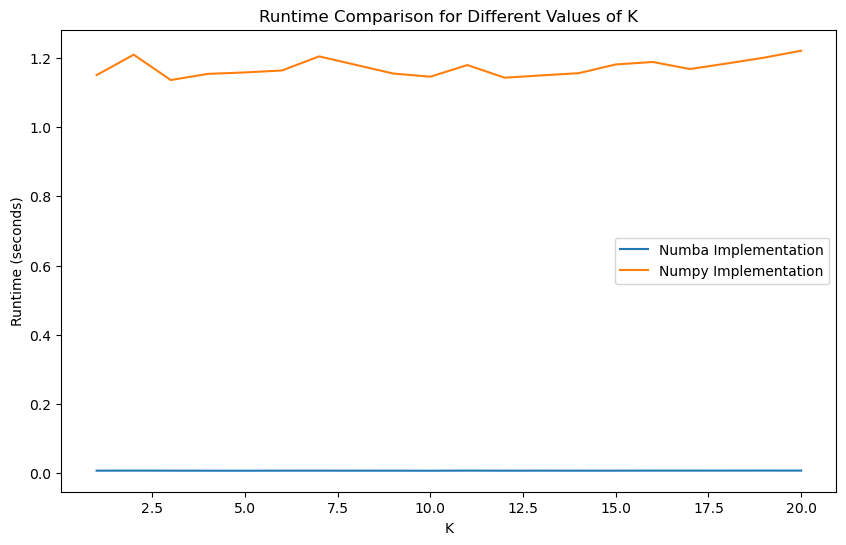

In [17]:
# your code

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import timeit
from numba import jit

# Define a range of K values to test
k_values = range(1, 21)

# Run the numba-accelerated version once to trigger compilation
_ = knn_classification_numba(x_train, class_train, x_test, n_neighbors=1)

# Measure runtime for the numba-accelerated version
numba_knn_runtimes = []
for k in k_values:
    numba_knn_runtime = timeit.timeit(lambda: knn_classification_numba(x_train, class_train, x_test, n_neighbors=k), number=10)
    numba_knn_runtimes.append(numba_knn_runtime)

# Measure runtime for the given knn_classification function
given_knn_runtimes = []
for k in k_values:
    given_knn_runtime = timeit.timeit(lambda: kNN(x_train, x_test, k, class_train), number=10)
    given_knn_runtimes.append(given_knn_runtime)

# Print the runtimes for both implementations
for k, numba_time, given_time in zip(k_values, numba_knn_runtimes, given_knn_runtimes):
    print(f"K = {k}:")
    print(f"Numba K-NN Runtime: {numba_time:.4f} seconds")
    print(f"Numpy K-NN Runtime: {given_time:.4f} seconds")
    print()

# Plot the runtime comparison
plt.figure(figsize=(10, 6))
plt.plot(k_values, numba_knn_runtimes, label='Numba Implementation')
plt.plot(k_values, given_knn_runtimes, label='Numpy Implementation')
plt.xlabel('K')
plt.ylabel('Runtime (seconds)')
plt.title('Runtime Comparison for Different Values of K')
plt.legend()

plt.show()